# Latent Drichelet Allocation algorithm implementation for cryptocurrency topic modelling

Importing required python libraries for LDA.
Parts of this code has been adopted https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
    
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [41]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['expect', 'from', 'subject', 're', 'use', 'issue', 'bug', 'error', 'test', 'remove', 'event', 'result', 'enable', 'support'])

# NLTK Stop words - Noun
from nltk.corpus import stopwords
stop_words_noun = stopwords.words('english')
stop_words_noun.extend(['case', 'from', 'subject', 're', 'show', 'crash', 'issue', 'error', 'support', 'bug', 'area','default'])

# NLTK Stop words - Verb
from nltk.corpus import stopwords
stop_words_verb = stopwords.words('english')
stop_words_verb.extend(['from', 'subject', 're', 'edu', 'use', 'issue'])

In [42]:
# Import Dataset
import chardet
import pandas as pd
df = pd.read_csv('tweets_wo_Loc_final.csv', encoding = "ISO-8859-1")
df.head()

,sr_no,screen_name,tweet_text
0,1,satoshifinder,satoshifinder blockchain user interface will d...
1,2,K28472777,k28472777 value broke $4540. lets start anounc...
2,3,K28472777,k28472777 beware bitcoin gold scam https://t.c...
3,4,anuraagjain,"anuraagjain rejoice #bitcoin &gt; $4500, targe..."
4,5,coinspeedZ,coinspeedz vitalik is no enemy of bitcoin. htt...


In [43]:
df.count()

sr_no           11394
 screen_name    11394
tweet_text      11394
dtype: int64

In [44]:
# Convert to list
data = df.tweet_text.values.tolist()
df.dtypes

sr_no            int64
 screen_name    object
tweet_text      object
dtype: object

Data Preprocessing using NLTK libraries 

In [45]:
# Remove special characters
data = [re.sub(r'[@#\$%&\*\(\)\<\>\?\'\";:\]\[-]', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

pprint(data[:1])

['satoshifinder blockchain user interface will deliver experiential value and '
 'speed up mainstream adoption https //t.co/pjoneqwfmd bitcoin']


In [46]:
#Tokenize words and Clean-up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['satoshifinder', 'blockchain', 'user', 'interface', 'will', 'deliver', 'experiential', 'value', 'and', 'speed', 'up', 'mainstream', 'adoption', 'https', 'co', 'pjoneqwfmd', 'bitcoin']]


In [47]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def remove_stopwords_noun(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_noun] for doc in texts]

def remove_stopwords_verb(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words_verb] for doc in texts]

In [48]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [49]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
len(data_words)
len(data_words)
print(data_words_nostops[13:14])

data_words_nostops_noun = remove_stopwords_noun(data_words)
len(data_words)
len(data_words_nostops_noun)
print(data_words_nostops[13:14])

data_words_nostops_verb = remove_stopwords_verb(data_words)
len(data_words)
len(data_words_nostops_verb)
print(data_words_nostops[1:2])

[['altcoinbot_io', 'stopped', 'sold', 'shift', 'position', 'loss', 'loss', 'altcoin', 'value', 'bitcoin']]
[['altcoinbot_io', 'stopped', 'sold', 'shift', 'position', 'loss', 'loss', 'altcoin', 'value', 'bitcoin']]
[['value', 'broke', 'lets', 'start', 'anouncing', 'value', 'every', 'https', 'co', 'lss', 'vahyp']]


In [50]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

data_lemmatized_noun = lemmatization(data_words_nostops_noun, allowed_postags=['NOUN'])
data_lemmatized_noun = [x for x in data_lemmatized_noun if x != []]

data_lemmatized_verb = lemmatization(data_words_nostops_verb, allowed_postags=['VERB'])
data_lemmatized_verb = [x for x in data_lemmatized_verb if x != []]

In [51]:
# Remove Stop Words from lemmatized words
data_lemmatized = remove_stopwords(data_lemmatized)
len(data_words)
len(data_lemmatized)
print(data_lemmatized[13:14])

data_lemmatized_noun = remove_stopwords_noun(data_lemmatized_noun)
len(data_words)
len(data_lemmatized_noun)
print(data_lemmatized_noun[13:14])

data_lemmatized_verb = remove_stopwords_verb(data_lemmatized_verb)
len(data_words)
len(data_lemmatized_verb)
print(data_lemmatized_verb[13:14])

[['stop', 'sell', 'shift', 'position', 'loss', 'loss', 'altcoin', 'value', 'bitcoin']]
[['shift', 'position', 'loss', 'loss', 'altcoin', 'value', 'bitcoin']]
[['allow', 'pay']]


In [52]:
#Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

id2word_noun = corpora.Dictionary(data_lemmatized_noun)

id2word_verb = corpora.Dictionary(data_lemmatized_verb)

In [53]:
# Create Corpus
texts = data_lemmatized

texts_noun = data_lemmatized_noun

texts_verb = data_lemmatized_verb

Document Term matrix for 3 LDA models

In [54]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

corpus_noun = [id2word_noun.doc2bow(text) for text in texts_noun]

corpus_verb = [id2word_verb.doc2bow(text) for text in texts_verb]

In [55]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[13:14]]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus_noun[13:14]]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus_verb[13:14]]


[[('scam', 1), ('anuraagjain', 1)]]

In [56]:
#Compute coherence score for whole corpus
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

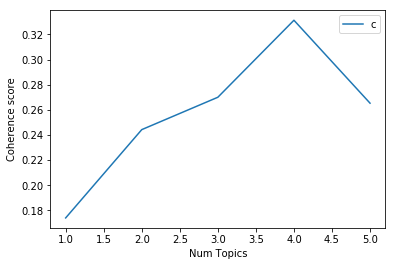

In [57]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=6, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
coherence_values

[0.36164336734461483,
 0.36164336734461483,
 0.36164336734461483,
 0.36164336734461483,
 0.36164336734461483]

In [31]:
x

range(1, 10)

In [27]:
#Building the Topic Model
# Build LDA model for whole text with 4 number of topics.
#Number of topics has been selected based on coherence score plot.
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Omkar\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.197146 -0.087692       1        1  35.492088
0      0.098308 -0.135932       2        1  30.966743
3     -0.320056 -0.072970       3        1  17.116837
2      0.024602  0.296594       4        1  16.424328, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
11    Default   4271.000000           value   4271.000000  30.0000  30.0000
45    Default   3583.000000            tech   3583.000000  29.0000  29.0000
33    Default   3950.000000        ethereum   3950.000000  28.0000  28.0000
5     Default  10423.000000           https  10423.000000  27.0000  27.0000
104   Default   1503.000000            join   1503.000000  26.0000  26.0000
2     Default   2541.000000      blockchain   2541.000000  25.0000  25.0000
32    Default   2373.000000  cryptocurrency   2373.000000  24.0000  24.0000
97    Default    631.000000        litecoin    631.000000  23.0000  23.0000
1046  Default    627.000000         airdrop    627.000000  22.0000  22.0000
1     Default   2053.000000         bitcoin   2053.000000  21.0000  21.0000
167   Default    931.000000           check    931.000000  20.0000  20.0000
1713  Default    497.000000            eltc    497.000000  19.0000  19.0000
1714  Default    500.000000         eltcoin    500.000000  18.0000  18.0000
439   Default    480.000000       introduce    480.000000  17.0000  17.0000
146   Default    484.000000             amp    484.000000  16.0000  16.0000
1717  Default    450.000000         valueiz    450.000000  15.0000  15.0000
947   Default    440.000000            blog    440.000000  14.0000  14.0000
359   Default    439.000000        upcoming    439.000000  13.0000  13.0000
1186  Default    756.000000        valueale    756.000000  12.0000  12.0000
4786  Default    429.000000           rjbbt    429.000000  11.0000  11.0000
5065  Default    421.000000         ethlend    421.000000  10.0000  10.0000
445   Default    600.000000            free    600.000000   9.0000   9.0000
464   Default    374.000000            hour    374.000000   8.0000   8.0000
29    Default    620.000000             btc    620.000000   7.0000   7.0000
153   Default    532.000000              go    532.000000   6.0000   6.0000
133   Default    529.000000    nologynology    529.000000   5.0000   5.0000
469   Default    348.000000          market    348.000000   4.0000   4.0000
214   Default    338.000000             new    338.000000   3.0000   3.0000
181   Default    326.000000        exchange    326.000000   2.0000   2.0000
68    Default    307.000000            week    307.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
181    Topic4    325.502289        exchange    326.304749   1.8039  -4.1395
1713   Topic4    495.961517            eltc    497.211273   1.8039  -3.7184
5065   Topic4    420.875519         ethlend    421.944061   1.8039  -3.8825
589    Topic4    291.891449           first    292.656952   1.8038  -4.2485
504    Topic4    241.670441          bitjob    242.417450   1.8033  -4.4373
602    Topic4    185.836975        increase    186.653412   1.8020  -4.7000
719    Topic4    174.899536           trend    175.672058   1.8020  -4.7607
204    Topic4    146.116699           could    146.845490   1.8014  -4.9405
190    Topic4    147.728668           world    148.489426   1.8013  -4.9295
184    Topic4    150.990326            make    151.803116   1.8010  -4.9077
205    Topic4    135.105499          dollar    135.836899   1.8010  -5.0188
509    Topic4    122.731430     marketplace    123.470680   1.8004  -5.1149
99     Topic4    120.703056         replace    121.430527   1.8004  -5.1315
511    Topic4    126.455711         student    127.220100   1.8004  -5.0850
1264   Topic4    125.049568          follow    125.809959   1

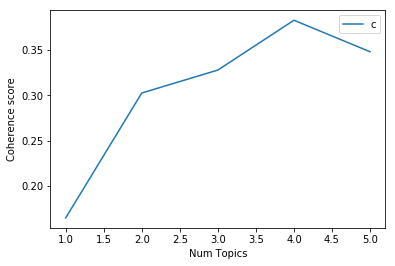

In [39]:
#Coherence values for Noun model
model_list, coherence_values_noun = compute_coherence_values(dictionary=id2word_noun, corpus=corpus_noun, texts=data_lemmatized_noun, start=1, limit=6, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_noun)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
#Building the Topic Model
# Build LDA model for noun with 4 number of topics
#Number of topics has been selected based on coherence score plot. 
lda_model_noun = gensim.models.ldamodel.LdaModel(corpus=corpus_noun,
                                           id2word=id2word_noun,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_noun = pyLDAvis.gensim.prepare(lda_model_noun, corpus_noun, id2word_noun)
vis_noun

C:\Omkar\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.348562 -0.011266       1        1  52.606285
2     -0.106982  0.263371       2        1  17.484238
3     -0.130799 -0.208539       3        1  16.868868
1     -0.110781 -0.043566       4        1  13.040606, topic_info=     Category         Freq            Term        Total  loglift  logprob
term                                                                     
6     Default  5064.000000           value  5064.000000  30.0000  30.0000
19    Default  4296.000000        ethereum  4296.000000  29.0000  29.0000
8     Default  3483.000000           https  3483.000000  28.0000  28.0000
31    Default  2723.000000            tech  2723.000000  27.0000  27.0000
18    Default  2702.000000  cryptocurrency  2702.000000  26.0000  26.0000
1     Default  2215.000000         bitcoin  2215.000000  25.0000  25.0000
23    Default  2017.000000      blockchain  2017.000000  24.0000  24.0000
696   Default   706.000000         airdrop   706.000000  23.0000  23.0000
68    Default   700.000000        litecoin   700.000000  22.0000  22.0000
1127  Default   545.000000            eltc   545.000000  21.0000  21.0000
1128  Default   545.000000         eltcoin   545.000000  20.0000  20.0000
628   Default   496.000000            blog   496.000000  19.0000  19.0000
301   Default   383.000000            hour   383.000000  18.0000  18.0000
105   Default   389.000000            sale   389.000000  17.0000  17.0000
76    Default   384.000000        platform   384.000000  16.0000  16.0000
3425  Default   480.000000           rjbbt   480.000000  15.0000  15.0000
440   Default   311.000000         article   311.000000  14.0000  14.0000
120   Default   362.000000        exchange   362.000000  13.0000  13.0000
91    Default   339.000000    nologynology   339.000000  12.0000  12.0000
90    Default   341.000000           hedge   341.000000  11.0000  11.0000
1035  Default   841.000000        valueale   841.000000  10.0000  10.0000
47    Default   293.000000            week   293.000000   9.0000   9.0000
30    Default   293.000000        security   293.000000   8.0000   8.0000
184   Default   282.000000           bonus   282.000000   7.0000   7.0000
87    Default   281.000000             usd   281.000000   6.0000   6.0000
1293  Default   264.000000             min   264.000000   5.0000   5.0000
17    Default   728.000000             btc   728.000000   4.0000   4.0000
185   Default   250.000000             day   250.000000   3.0000   3.0000
179   Default   600.000000         project   600.000000   2.0000   2.0000
109   Default   578.000000           check   578.000000   1.0000   1.0000
...       ...          ...             ...          ...      ...      ...
4173   Topic4   146.972290            hero   147.689896   2.0322  -4.3020
198    Topic4   126.820259            mark   127.473656   2.0320  -4.4495
331    Topic4   124.444893      freelancer   125.123711   2.0317  -4.4684
424    Topic4   121.445679            coin   122.117607   2.0316  -4.4928
330    Topic4   123.034058        employer   123.746056   2.0313  -4.4798
133    Topic4   113.156982         service   113.889275   2.0307  -4.5635
309    Topic4   104.210876             cap   104.895531   2.0306  -4.6459
44     Topic4    97.549362            time    98.215599   2.0303  -4.7119
697    Topic4    87.887947          bitjob    88.556328   2.0295  -4.8162
57     Topic4    83.980072        investor    84.632904   2.0294  -4.8617
353    Topic4    90.224548            http    90.937607   2.0292  -4.7900
1213   Topic4    94.659462           click    95.422691   2.0291  -4.7420
394    Topic4    66.700844           china    67.355461   2.0273  -5.0921
2641   Topic4    64.792374          winner    65.453812   2.0269  -5.1211
5576   Topic4    65.881775         upgrade    66.560051   2.0269  -5.1044
843    Topic4    59.796017            wall    60.450638   2.0262  -5.2013
370    

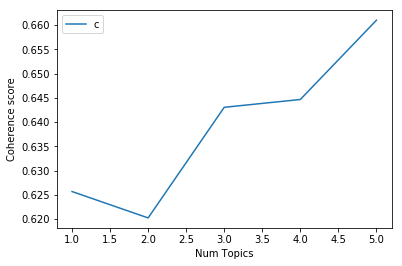

In [34]:
model_list_verb, coherence_values_verb = compute_coherence_values(dictionary=id2word_verb, corpus=corpus_verb, texts=data_lemmatized_verb, start=1, limit=6, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_verb)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
#Building the Topic Model
# Build LDA model for verb with 4 number of topics
#Number of topics has been selected based on coherence score plot.
lda_model_verb = gensim.models.ldamodel.LdaModel(corpus=corpus_verb,
                                           id2word=id2word_verb,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)


In [38]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_verb = pyLDAvis.gensim.prepare(lda_model_verb, corpus_verb, id2word_verb)
vis_verb

C:\Omkar\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.384928 -0.011503       1        1  57.141388
1     -0.113655  0.131754       2        1  15.751325
3     -0.129478  0.190902       3        1  14.003409
0     -0.141795 -0.311153       4        1  13.103882, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
2     Default  7701.000000         https  7701.000000  30.0000  30.0000
90    Default   507.000000     introduce   507.000000  29.0000  29.0000
287   Default   477.000000       valueiz   477.000000  28.0000  28.0000
22    Default  1186.000000          join  1186.000000  27.0000  27.0000
191   Default   328.000000          read   328.000000  26.0000  26.0000
63    Default   305.000000          come   305.000000  25.0000  25.0000
37    Default   235.000000          make   235.000000  24.0000  24.0000
128   Default   205.000000      increase   205.000000  23.0000  23.0000
146   Default   196.000000       perform   196.000000  22.0000  22.0000
80    Default   180.000000          lend   180.000000  21.0000  21.0000
65    Default   164.000000          base   164.000000  20.0000  20.0000
12    Default   144.000000          list   144.000000  19.0000  19.0000
236   Default   153.000000          know   153.000000  18.0000  18.0000
31    Default   134.000000         break   134.000000  17.0000  17.0000
161   Default   135.000000       involve   135.000000  16.0000  16.0000
5     Default   133.000000         start   133.000000  15.0000  15.0000
51    Default   132.000000        invest   132.000000  14.0000  14.0000
137   Default   128.000000         thank   128.000000  13.0000  13.0000
310   Default   115.000000          live   115.000000  12.0000  12.0000
32    Default   417.000000            go   417.000000  11.0000  11.0000
612   Default   107.000000     integrate   107.000000  10.0000  10.0000
248   Default   102.000000  decentralize   102.000000   9.0000   9.0000
75    Default   110.000000           buy   110.000000   8.0000   8.0000
260   Default   109.000000         speak   109.000000   7.0000   7.0000
152   Default   103.000000          want   103.000000   6.0000   6.0000
187   Default   102.000000       retweet   102.000000   5.0000   5.0000
108   Default    96.000000           see    96.000000   4.0000   4.0000
28    Default    88.000000           may    88.000000   3.0000   3.0000
78    Default    84.000000         would    84.000000   2.0000   2.0000
91    Default    86.000000          send    86.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
31     Topic4   134.099838         break   134.869827   2.0265  -3.1447
146    Topic4   194.972366       perform   196.451477   2.0247  -2.7704
248    Topic4   101.529510  decentralize   102.331940   2.0244  -3.4229
119    Topic4    70.617012        launch    71.395996   2.0213  -3.7860
203    Topic4    77.078522       provide    77.951584   2.0210  -3.6985
331    Topic4    60.725365      announce    61.527439   2.0191  -3.9369
118    Topic4    55.620525       publish    56.392685   2.0185  -4.0247
412    Topic4    54.366585       discuss    55.169792   2.0176  -4.0475
328    Topic4    52.202545           add    53.009972   2.0169  -4.0881
245    Topic4    40.931484        become    41.707165   2.0135  -4.3314
84     Topic4    34.499165          find    35.272839   2.0101  -4.5023
921    Topic4    35.884087          vote    36.697453   2.0098  -4.4630
364    Topic4    39.081680    accelerate    40.031395   2.0083  -4.3776
327    Topic4    32.751320         value    33.585819   2.0071  -4.5543
212    Topic4    28.007816         leave    28.841616   2.0029  -4.7108
103    Topic4    24.550877          miss    25.310553   2.0018  -4.8425
222    Topic4    21.963219          post    22.764397   1.9964  -4.9539
234    Topic4    23.366129       